Saving medical_examination.csv to medical_examination.csv


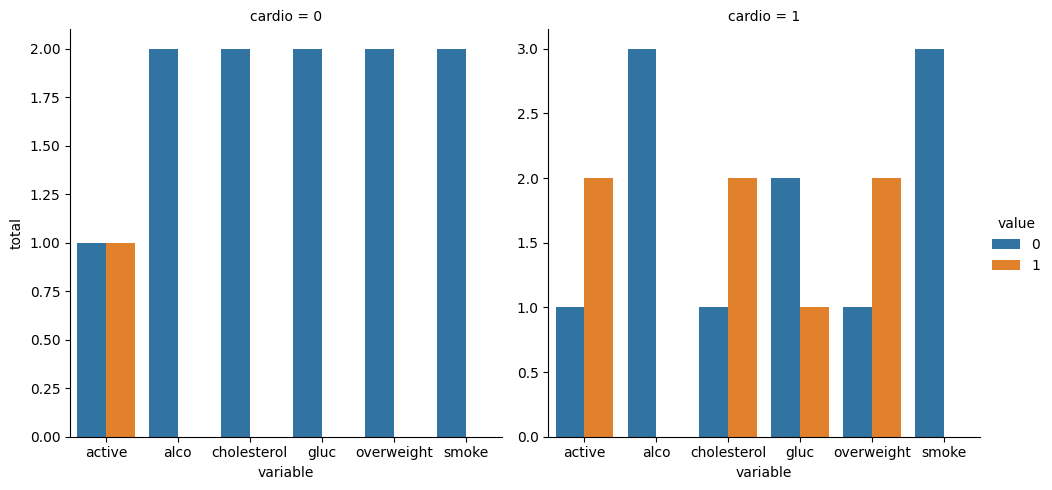

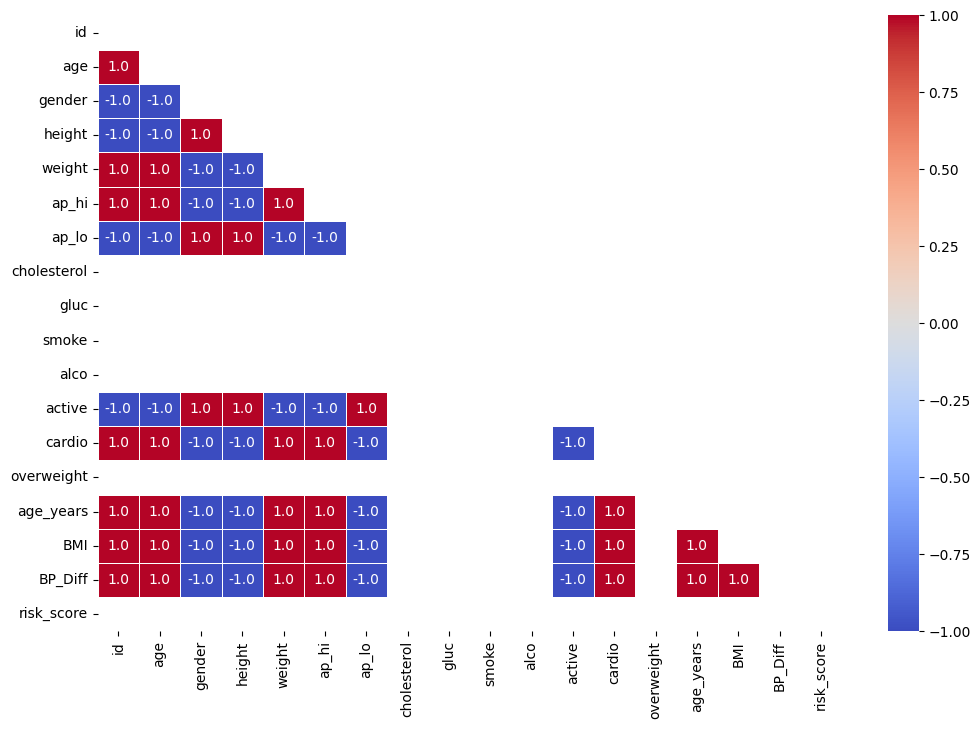


🌲 Random Forest Accuracy: 1.0

📋 Random Forest Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


📈 Logistic Regression Accuracy: 1.0

📋 Logistic Regression Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


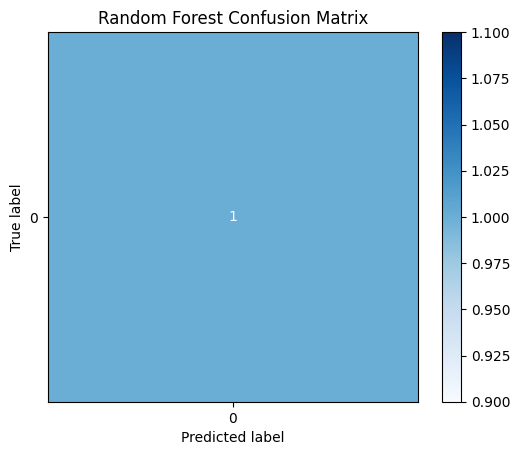

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


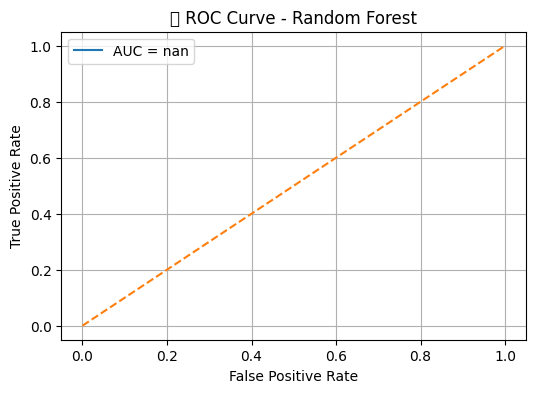

<ipython-input-3-852db99837f3>:128: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


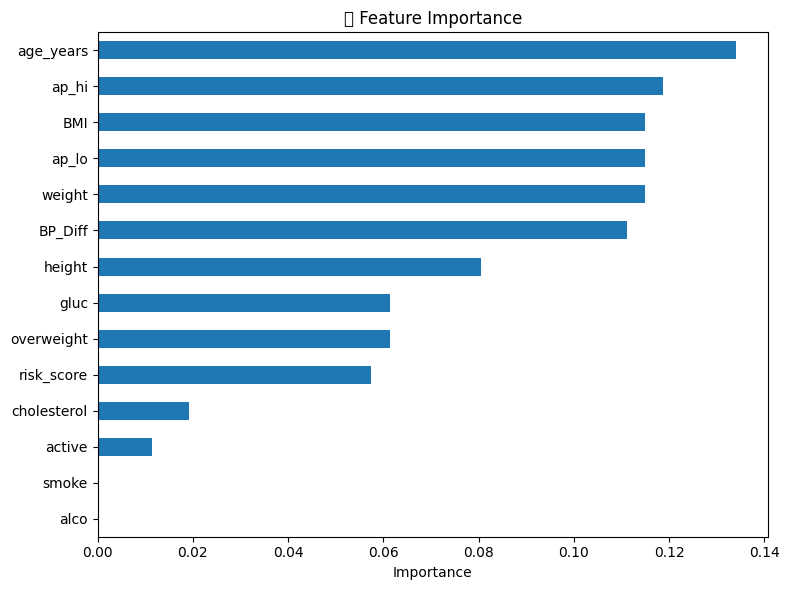

In [3]:
# 📦 Import Libraries
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score,
    ConfusionMatrixDisplay
)

# 📁 Upload CSV File
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

# 🔧 Preprocess Data
def preprocess_data(df):
    df['overweight'] = ((df['weight'] / ((df['height'] / 100) ** 2)) > 25).astype(int)
    df['cholesterol'] = (df['cholesterol'] > 1).astype(int)
    df['gluc'] = (df['gluc'] > 1).astype(int)
    return df

df = preprocess_data(df)

# 🧠 Feature Engineering
df['age_years'] = (df['age'] / 365).astype(int)
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
df['BP_Diff'] = df['ap_hi'] - df['ap_lo']
df['risk_score'] = df[['cholesterol', 'gluc', 'smoke', 'alco', 'overweight']].sum(axis=1)

# 📊 Categorical Plot
def draw_cat_plot(df):
    df_cat = pd.melt(df, id_vars=["cardio"],
                     value_vars=["cholesterol", "gluc", "smoke", "alco", "active", "overweight"])
    df_cat = df_cat.groupby(["cardio", "variable", "value"]).size().reset_index(name="total")

    fig = sns.catplot(x="variable", y="total", hue="value", col="cardio",
                      data=df_cat, kind="bar", height=5, aspect=1, sharey=False).fig
    plt.show()
    return fig

draw_cat_plot(df)

# 🔥 Heatmap
def draw_heat_map(df):
    df_heat = df[
        (df['ap_lo'] <= df['ap_hi']) &
        (df['height'].between(df['height'].quantile(0.025), df['height'].quantile(0.975))) &
        (df['weight'].between(df['weight'].quantile(0.025), df['weight'].quantile(0.975)))
    ]

    corr = df_heat.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
    sns.heatmap(corr, annot=True, fmt=".1f", mask=mask, cmap="coolwarm", ax=ax, linewidths=0.5)
    plt.show()
    return fig

draw_heat_map(df)

# 🤖 Machine Learning Model + Evaluation
def train_ml_model(df):
    df_clean = df.dropna()

    # Features and Target
    features = ['age_years', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI', 'BP_Diff',
                'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'overweight', 'risk_score']
    X = df_clean[features]
    y = df_clean['cardio']

    # Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # ✅ Random Forest Classifier
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    print("\n🌲 Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
    print("\n📋 Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

    # ✅ Logistic Regression (Baseline)
    log_model = LogisticRegression(max_iter=1000)
    log_model.fit(X_train, y_train)
    y_pred_log = log_model.predict(X_test)

    print("\n📈 Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
    print("\n📋 Logistic Regression Report:\n", classification_report(y_test, y_pred_log))

    # ✅ Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_rf)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title("Random Forest Confusion Matrix")
    plt.show()

    # ✅ ROC Curve & AUC Score
    y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
    auc_score = roc_auc_score(y_test, y_proba_rf)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title("🔵 ROC Curve - Random Forest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ✅ Feature Importance
    feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
    feat_imp.sort_values().plot(kind='barh', title='🔍 Feature Importance', figsize=(8, 6))
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# 🚀 Run Full ML Pipeline
train_ml_model(df)
